In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
import statsmodels.api as sm
import statsmodels.graphics as stgraph
from pmdarima import arima
from scipy import stats
from itertools import product
import warnings
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import normaltest
from statsmodels.tsa.statespace.sarimax import SARIMAX
from dateutil.relativedelta import relativedelta

In [ ]:
%matplotlib inline
sns.set_style("whitegrid")

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
def plot_dynamics(data, point):
    plt.figure(figsize=(20,5))
    #plt.scatter(data.index, data.values, s=1)
    plt.plot(data)
    plt.xlabel("Time")
    plt.ylabel("The number of publications")
    plt.title(point)
    plt.show()

In [ ]:
def plot_decomposition(x_data, years, period):
    ts_dicomposition = sm.tsa.seasonal_decompose(x_data, model='additive', period=period)
    trend_estimate = ts_dicomposition.trend
    seasonal_estimate = ts_dicomposition.seasonal
    residual_estimate = ts_dicomposition.resid

    fig, axes = plt.subplots(4, 1)
    fig.set_figheight(10)
    fig.set_figwidth(20)
    # First plot is the Original time series
    axes[0].plot(x_data, label='Original')
    axes[0].legend(loc='upper left')
    # Second plot is the trend
    axes[1].plot(trend_estimate, label='Trend')
    axes[1].legend(loc='upper left')
    # Third plot is the Seasonality component
    axes[2].plot(seasonal_estimate, label='Seasonality')
    axes[2].legend(loc='upper left')
    # The last plot is the Residual component
    axes[3].scatter(years, residual_estimate, label='Residuals', s=2)
    axes[3].legend(loc='upper left')

In [ ]:
def plot_acf_pacf(x_data, acf_lags, pacf_lags):
    fig, ax = plt.subplots(2, 1, figsize=(20,8))
    # autocorrelation
    sm.graphics.tsa.plot_acf(x_data, lags=acf_lags, ax=ax[0])
    # partial autocorrelation
    sm.graphics.tsa.plot_pacf(x_data, lags=pacf_lags, ax=ax[1])

    plt.show()

In [ ]:
def calculate_period(data, resample=False):
    acf_val = sm.tsa.stattools.acf(data, nlags=len(data))
    period_lst = []
    for i in range(len(acf_val) - 1):
        if acf_val[i] * acf_val[i+1] < 0:
            period_lst.append(i)

    if len(period_lst) % 2 != 0:
        period_lst = period_lst[:-1]

    curr_id = 0
    period_diff = []
    while curr_id + 2 < len(period_lst):
        period_diff.append(period_lst[curr_id+2] - period_lst[curr_id])
        curr_id += 2

    period = sum(period_diff) / len(period_diff)
    if resample:
        print(f"The duration of the season is equal to: {period * 3}" )
    else:
        print(f"The duration of the season is equal to: {period}" )

    return period

In [ ]:
def adfuller_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [ ]:
def get_fourier_features(n_order, period, values):
    fourier_features = pd.DataFrame(
        {
            f"fourier_{func}_order_{order}": getattr(np, func)(
                2 * np.pi * values * order / period
            )
            for order in range(1, n_order + 1)
            for func in ("sin", "cos")
        }
    )
    return fourier_features

In [ ]:
def plot_lag(data):
    lag_plot(data)

In [ ]:
def regular_differencing(data):
    return diff(data, k_diff=1)

In [ ]:
def box_cox_transform(data):
    return stats.boxcox(data)

In [ ]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y + 1)/lmbda)

###Read Data

In [ ]:
PATH = "/content/drive/My Drive/ITMO/IndML'23/train_valid_data/"

valid_df = pd.read_csv(PATH + "validation_data.csv", delimiter=",")
train_df = pd.read_pickle(PATH + "selected_data_1.pickle")

train_df_no_split = pd.read_pickle(PATH + "selected_data.pickle")

valid_df[['hour', 'lat', 'lon', 'point', 'sum', 'error']] = pd.DataFrame(valid_df['hour,lat,lon,point,sum,error'].str.split(',').tolist())
valid_df = valid_df.drop(labels="hour,lat,lon,point,sum,error", axis=1)

In [ ]:
train_df.keys()

dict_keys(['train', 'val'])

In [ ]:
valid_df

,hour,lat,lon,point,sum,error
0,1582448400,59.92698583598656,30.318140839033845,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,5,0.4214019228009757
1,1582225200,59.92473501631175,30.241784039883687,0101000020E6100000C5FE0F8FE53D3E4033438EB75DF6...,14,0.3102908116898645
2,1581260400,60.00230010204685,30.295682956930857,0101000020E6100000AB00D6E0B14B3E40CB88A75E4B00...,5,3.754735256134309
3,1581958800,59.935987587847,30.324878203664746,0101000020E61000005DECCB372B533E40E4A1F770CEF7...,7,0.504735256134309
4,1582779600,59.93373737889392,30.30691189798236,0101000020E6100000669634C7914E3E407AB3D8B484F7...,14,1.5547352561343089
...,...,...,...,...,...,...
681,1580659200,59.90559688321354,30.29792874514116,0101000020E61000006AEBE80E454C3E407F614299EAF3...,7,2.254735256134309
682,1581048000,59.95061022518379,30.315895050823546,0101000020E61000006141807FDE503E402B348A98ADF9...,8,6.754735256134309
683,1581656400,59.93373737889392,30.30915768619265,0101000020E6100000268147F5244F3E407AB3D8B484F7...,6,4.754735256134309
684,1580724000,59.931487017270754,30.358565026819228,0101000020E61000008EADE7EACA5B3E40CAE971F73AF7...,8,1.4214019228009758


In [ ]:
train, val = train_df["train"], train_df["val"]

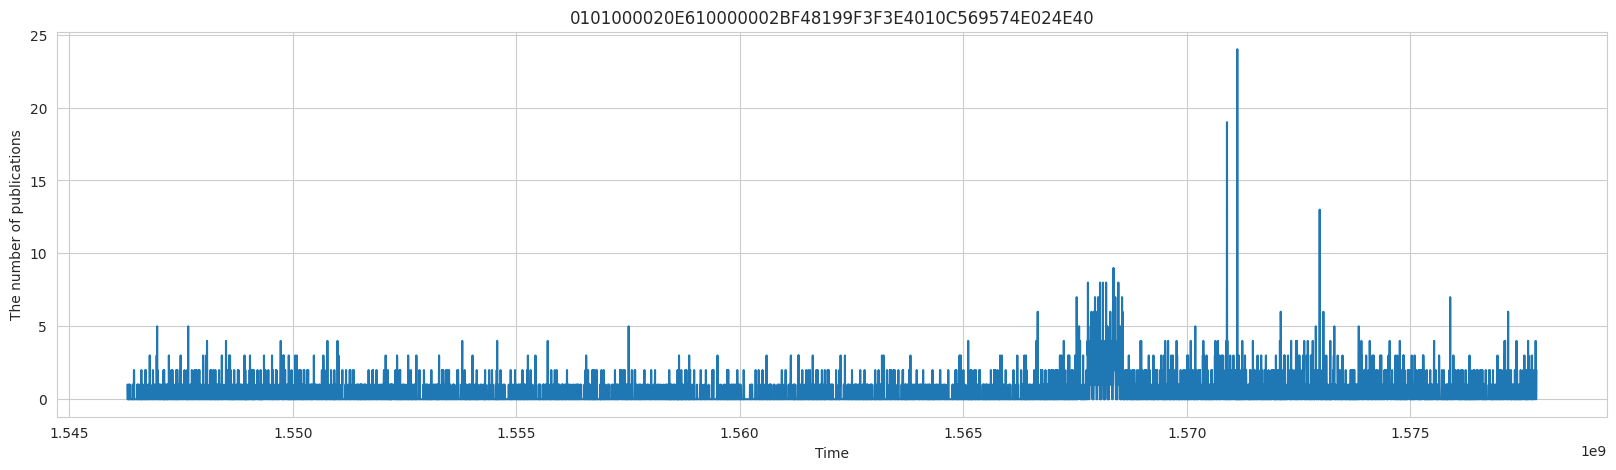

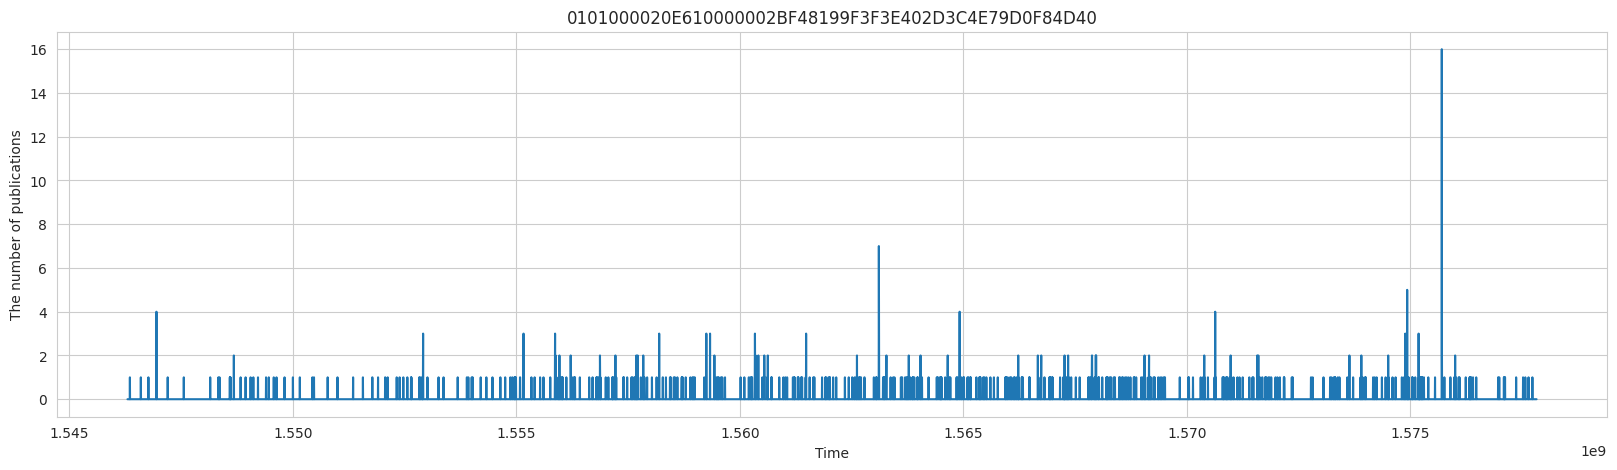

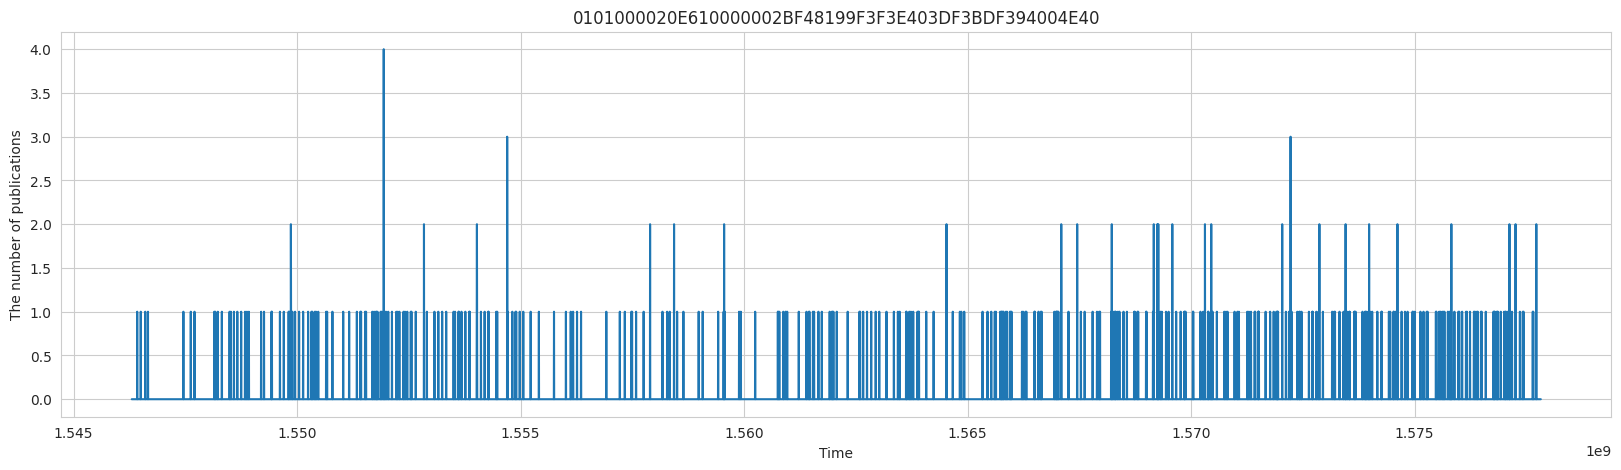

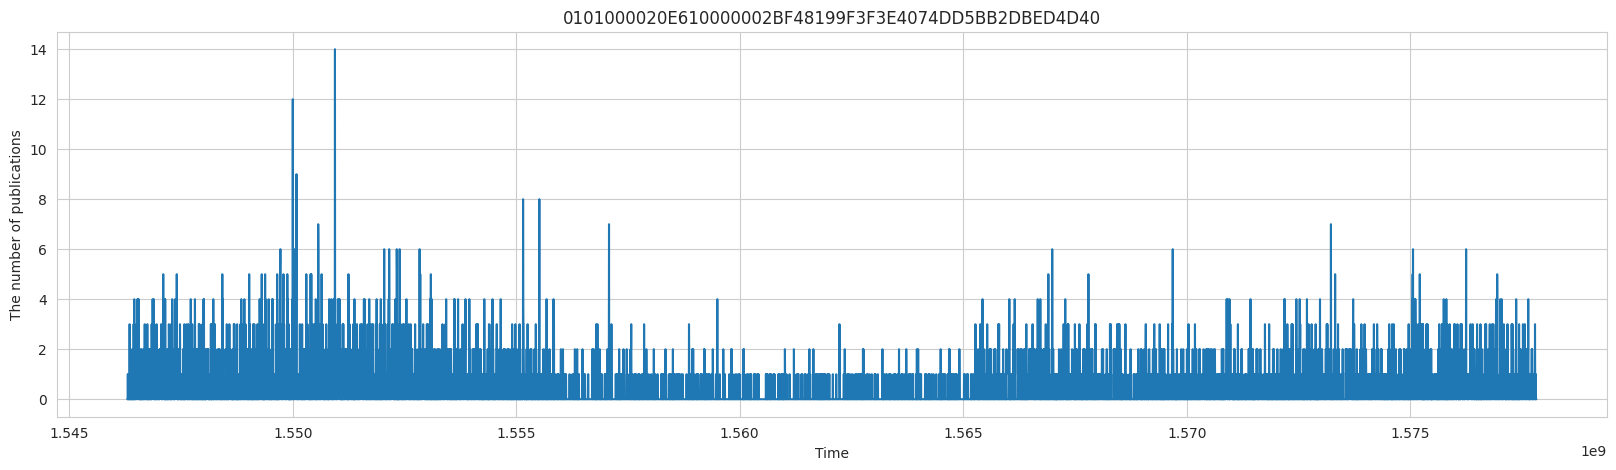

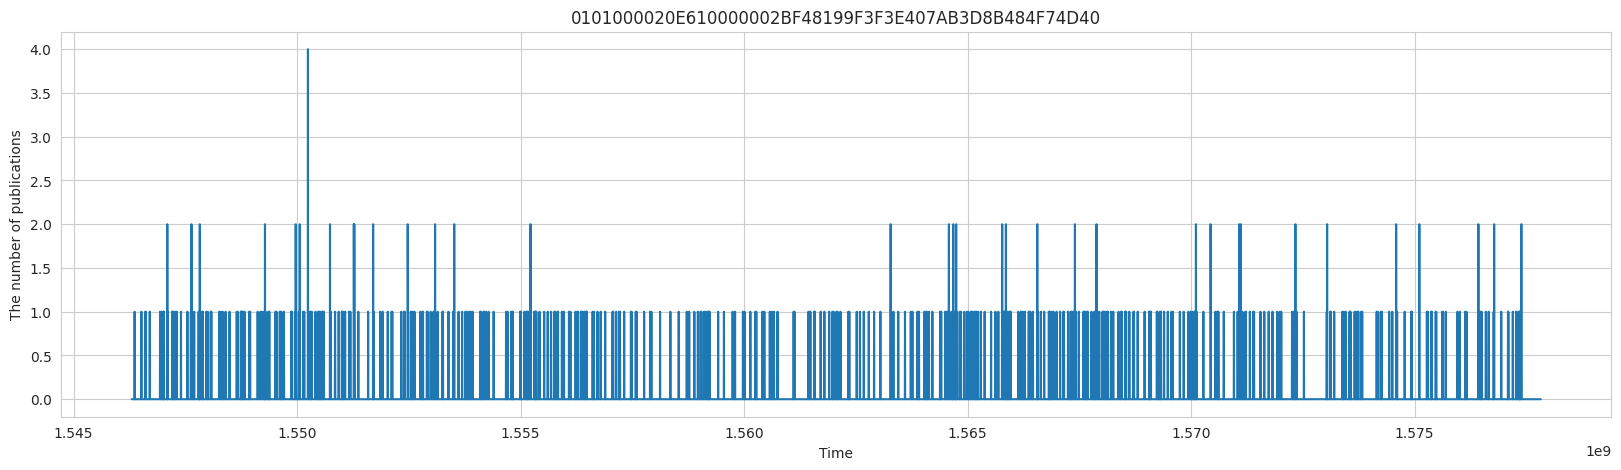

In [ ]:
for i in range(5):
    plot_dynamics(train["groups"][i], train["points"][i])

### One sample analysis

In [ ]:
most_pop_point = "0101000020E6100000669634C7914E3E407AB3D8B484F74D40"
most_pop_id = None
for i, point in enumerate(train["points"]):
    if point == most_pop_point:
        most_pop_id = i

In [ ]:
#sample_point = valid_df["point"][0]
#
#sample_data = train_df["groups"][train_df["points"]==sample_point]

#sample_point = train["points"][2]
#sample_data = train["groups"][2]

sample_point = most_pop_point
sample_data = train["groups"][most_pop_id]

# Aggregate data by day
sample_data_df = sample_data.to_frame()
sample_data_df = sample_data_df.reset_index(level=['timestamp'])
sample_data_df["timestamp"] = [datetime.datetime.fromtimestamp(timestamp) for timestamp in sample_data_df["timestamp"]]

sample_data_day = sample_data_df.resample('1D', on='timestamp')['n_pubs'].sum().reset_index()
sample_data_day

,timestamp,n_pubs
0,2019-01-01,193.0
1,2019-01-02,357.0
2,2019-01-03,418.0
3,2019-01-04,414.0
4,2019-01-05,456.0
...,...,...
360,2019-12-27,691.0
361,2019-12-28,498.0
362,2019-12-29,708.0
363,2019-12-30,935.0


In [ ]:
pd.DataFrame(sample_data).to_csv("TS.csv")

In [ ]:
test_sample = val["groups"][most_pop_id]
# Aggregate data by day
test_sample_data_df = test_sample.to_frame()
test_sample_data_df = test_sample_data_df.reset_index(level=['timestamp'])
test_sample_data_df["timestamp"] = [datetime.datetime.fromtimestamp(timestamp) for timestamp in test_sample_data_df["timestamp"]]

test_sample_data_day = test_sample_data_df.resample('1D', on='timestamp')['n_pubs'].sum().reset_index()

In [ ]:
most_pop_id_no_split = None
for i, point in enumerate(train_df_no_split["points"]):
    if point == most_pop_point:
        most_pop_id_no_split = i

train_sample_no_split = train_df_no_split["groups"][most_pop_id_no_split]
# Aggregate data by day
train_sample_data_no_split_df = train_sample_no_split.to_frame()
train_sample_data_no_split_df = train_sample_data_no_split_df.reset_index(level=['timestamp'])
train_sample_data_no_split_df["timestamp"] = [datetime.datetime.fromtimestamp(timestamp) for timestamp in train_sample_data_no_split_df["timestamp"]]

train_sample_data_day_no_split = train_sample_data_no_split_df.resample('1D', on='timestamp')['n_pubs'].sum().reset_index()

train_sample_data_day_no_split

,timestamp,n_pubs
0,2019-01-01,193.0
1,2019-01-02,357.0
2,2019-01-03,418.0
3,2019-01-04,414.0
4,2019-01-05,456.0
...,...,...
391,2020-01-27,886.0
392,2020-01-28,863.0
393,2020-01-29,731.0
394,2020-01-30,776.0


In [ ]:
# Split train/test
ratio = 0.8

train_data = train_sample_data_day_no_split[:round(len(train_sample_data_day_no_split)*ratio)]
test_data = train_sample_data_day_no_split[round(len(train_sample_data_day_no_split)*ratio):]

print(train_data.shape, test_data.shape)

(317, 4) (79, 4)


In [ ]:
# Validation
valid_data_error = valid_df[valid_df["point"]==most_pop_point]

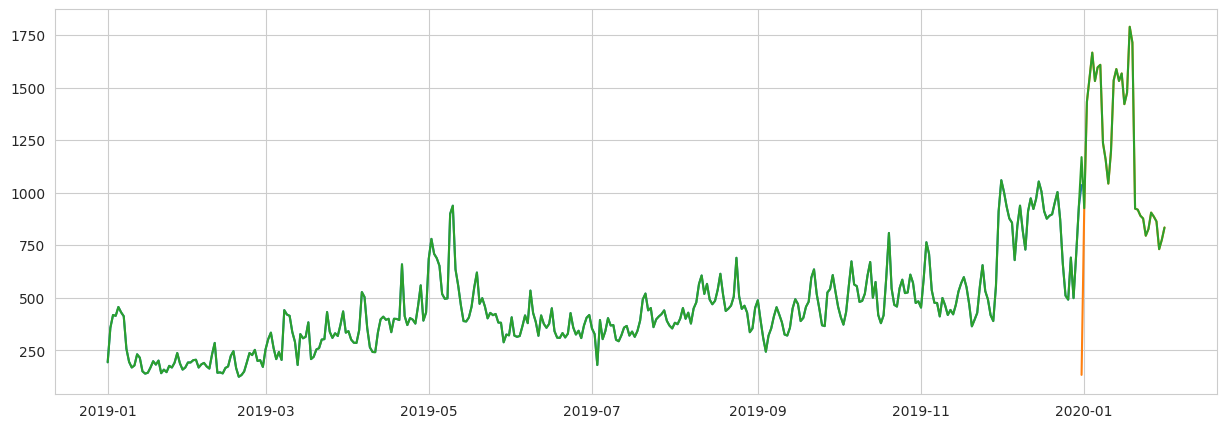

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(sample_data_day["timestamp"], sample_data_day["n_pubs"])
plt.plot(test_sample_data_day["timestamp"], test_sample_data_day["n_pubs"])
plt.plot(train_sample_data_day_no_split["timestamp"], train_sample_data_day_no_split["n_pubs"])

In [ ]:
#Set the dataset
sample_data_day = train_sample_data_day_no_split
#sample_data_day = train_data

In [ ]:
analysis_pipeline = {
    "Plot": plot_dynamics,
    "Seasonal decomposition": plot_decomposition,
    "Plot lag": plot_lag,
    "ACF PACF": plot_acf_pacf,
    "Seasonality Test": adfuller_test,
    "Regular Differencing": regular_differencing,
    "Box-Cox": box_cox_transform
}

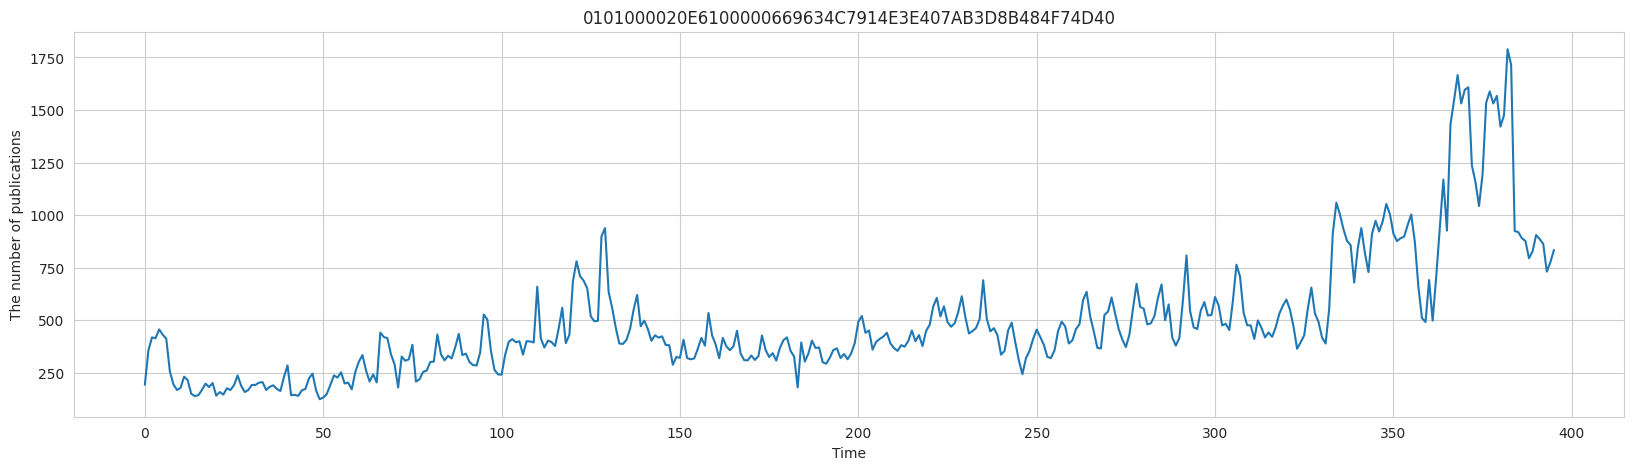

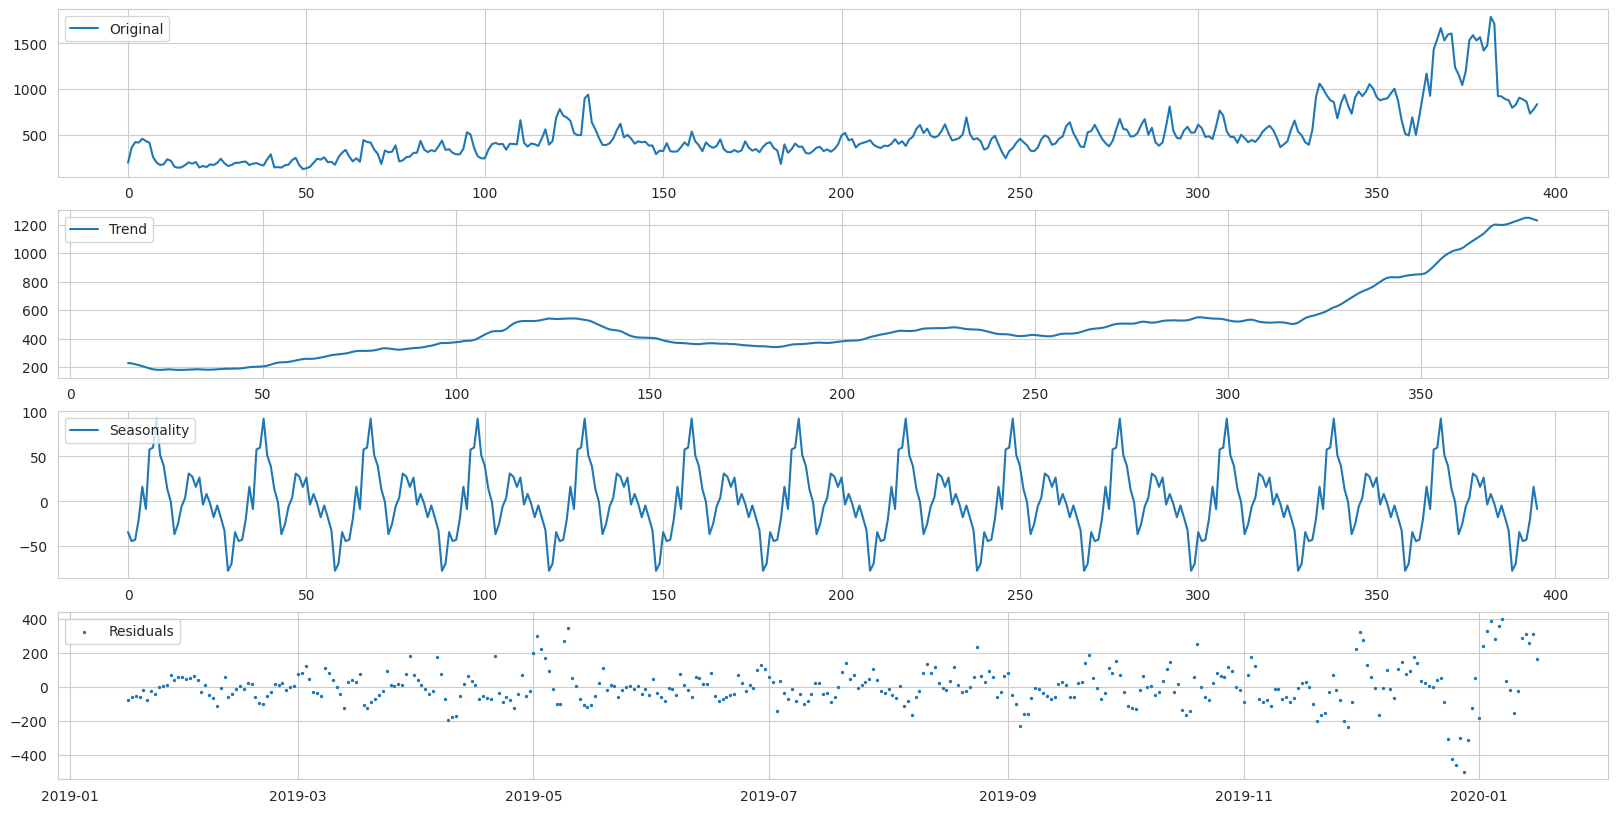

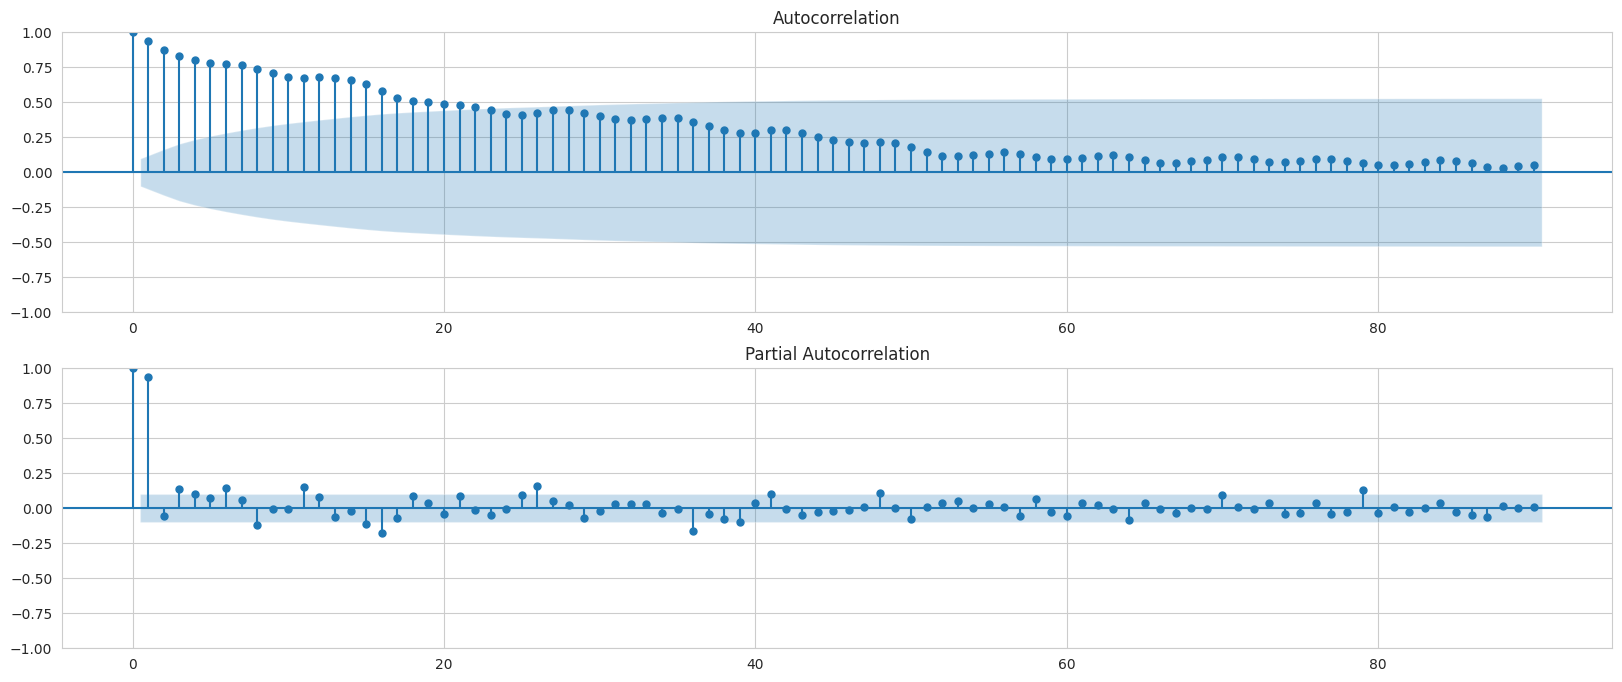

In [ ]:
analysis_pipeline["Plot"](sample_data_day["n_pubs"], sample_point)
analysis_pipeline["Seasonal decomposition"](sample_data_day["n_pubs"], sample_data_day["timestamp"], period=30)
analysis_pipeline["ACF PACF"](sample_data_day["n_pubs"], acf_lags=90, pacf_lags=90)

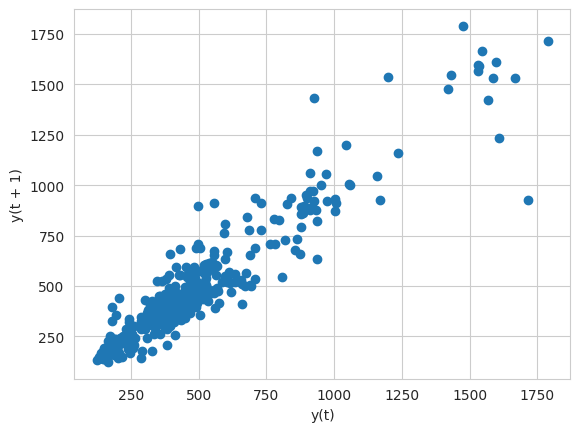

In [ ]:
analysis_pipeline["Plot lag"](sample_data_day["n_pubs"])

In [ ]:
analysis_pipeline["Seasonality Test"](sample_data_day["n_pubs"])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.001376
p-value                   0.285970
# lags used              17.000000
# observations          378.000000
critical value (1%)      -3.447769
critical value (5%)      -2.869217
critical value (10%)     -2.570860
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


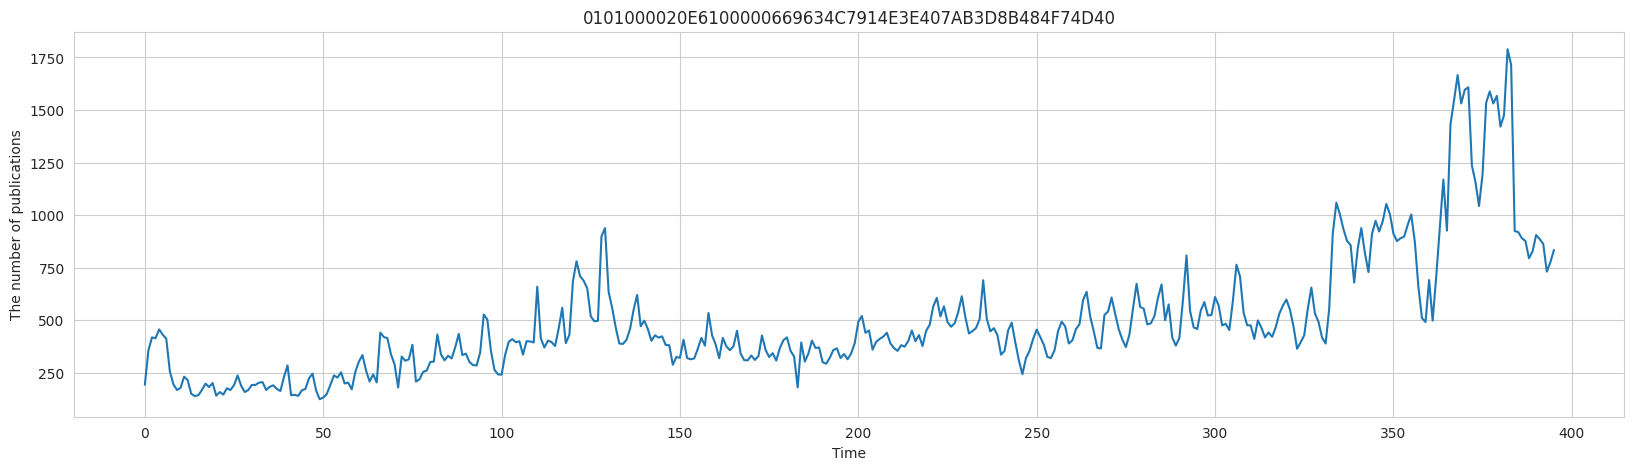

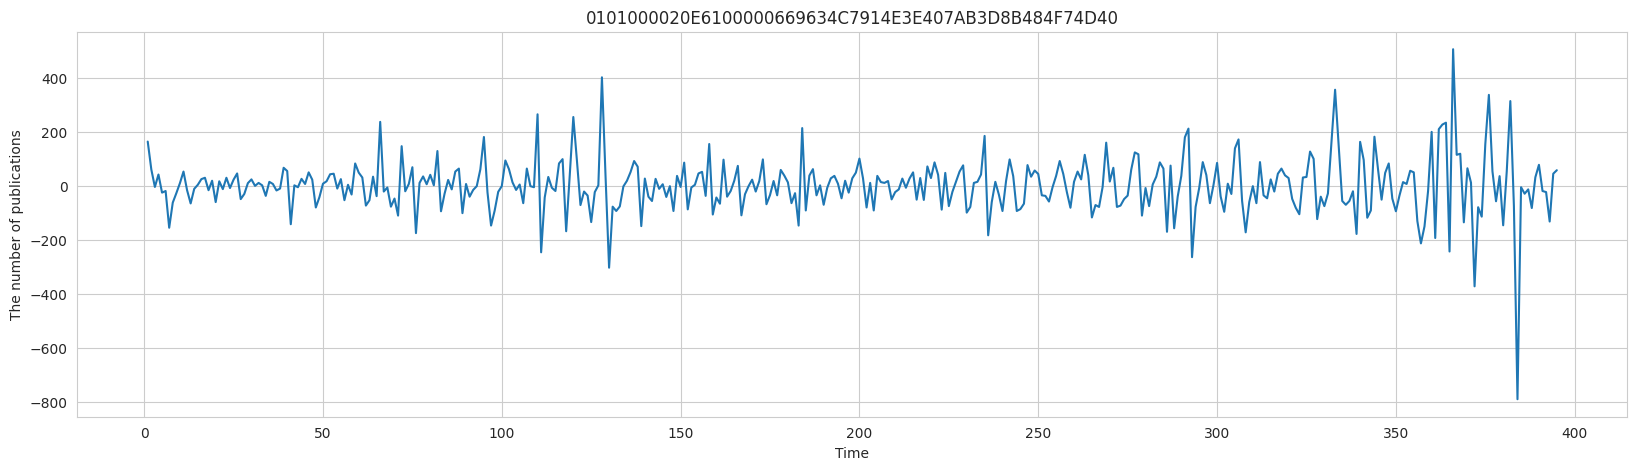

In [ ]:
sample_data_day["diff_1"] = analysis_pipeline["Regular Differencing"](sample_data_day["n_pubs"])
analysis_pipeline["Plot"](sample_data_day["n_pubs"], sample_point)
analysis_pipeline["Plot"](sample_data_day["diff_1"], sample_point)

In [ ]:
analysis_pipeline["Seasonality Test"](sample_data_day["diff_1"])

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.194689
p-value                   0.000009
# lags used              17.000000
# observations          377.000000
critical value (1%)      -3.447815
critical value (5%)      -2.869237
critical value (10%)     -2.570870
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


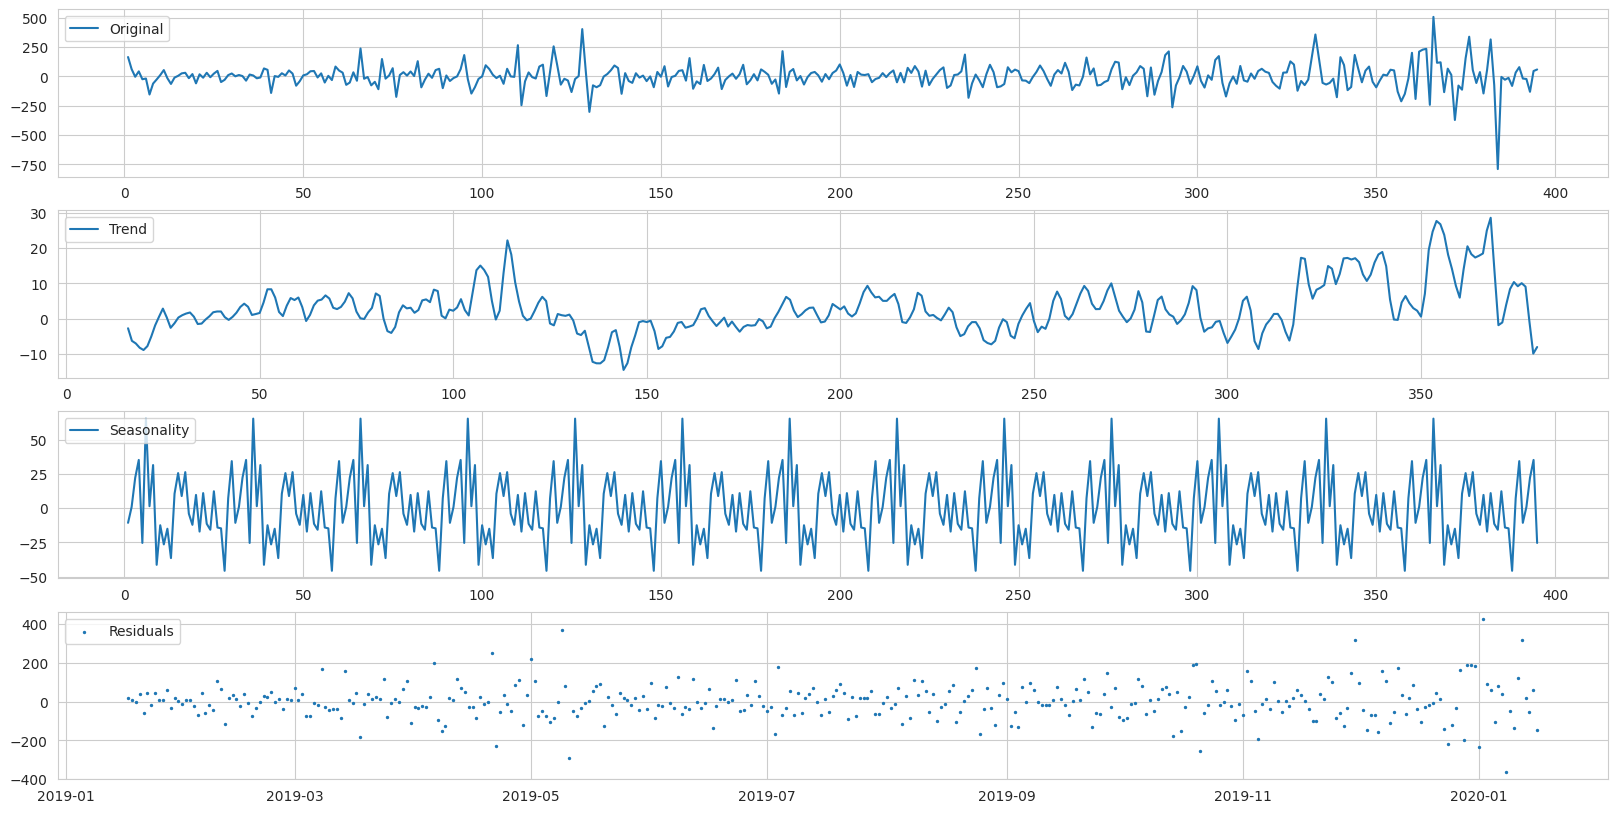

In [ ]:
analysis_pipeline["Seasonal decomposition"](sample_data_day["diff_1"][1:], sample_data_day["timestamp"][1:], period=30)

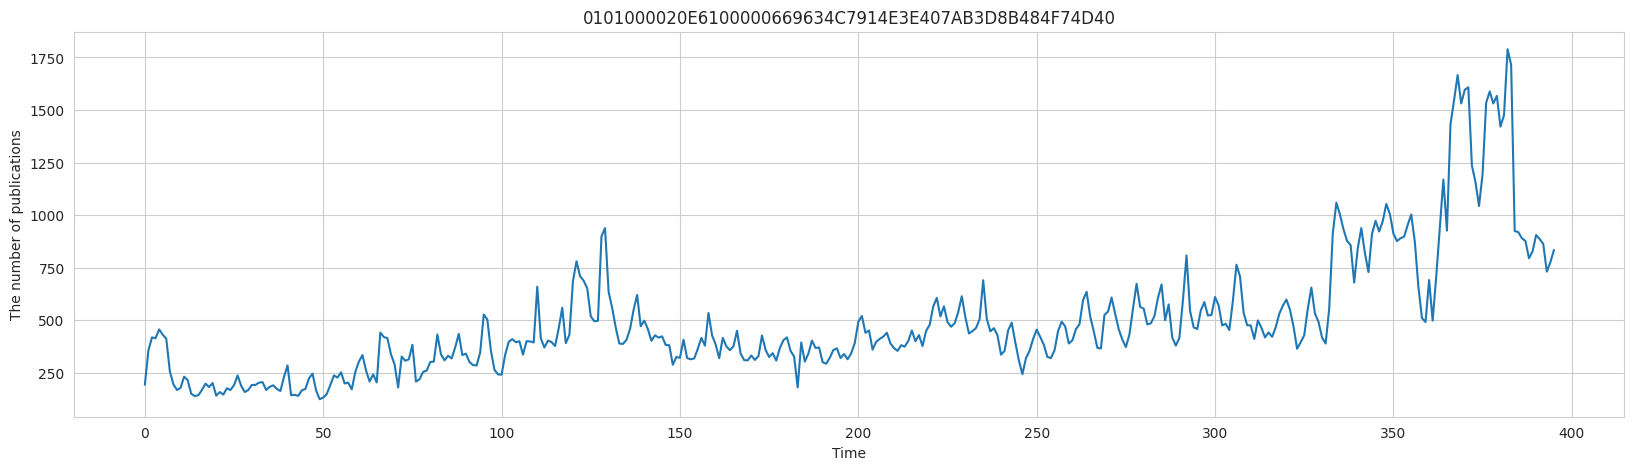

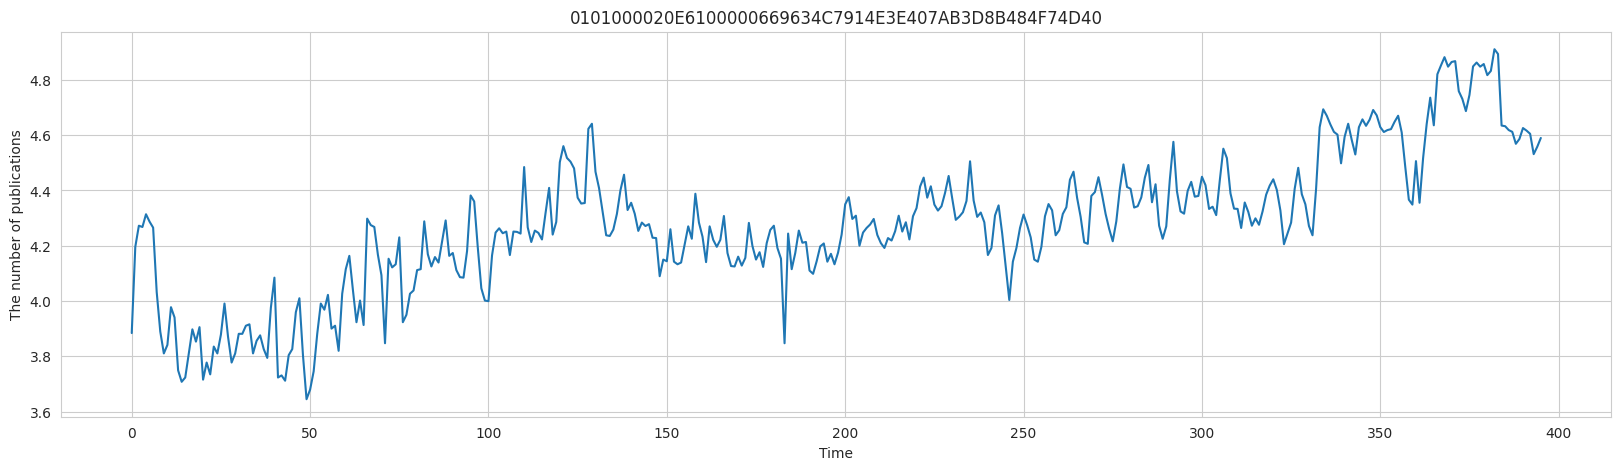

In [ ]:
sample_data_day["box_cox"], box_cox_lmbd = analysis_pipeline["Box-Cox"](sample_data_day["n_pubs"])
analysis_pipeline["Plot"](sample_data_day["n_pubs"], sample_point)
analysis_pipeline["Plot"](sample_data_day["box_cox"], sample_point)

This shows very strong autocorrelation; as y(t) values increase, nearby lagged values also increase

ACF: The slow decrease in the ACF as the lags increase is due to the trend, while the “scalloped” shape is due the seasonality.

##ARIMA

In [ ]:
auto_arima_results = arima.auto_arima(sample_data_day["n_pubs"],
                                    start_p=0,
                                    start_q=0,
                                    max_p=10,
                                    max_q=10, # maximum p and q
                                    m=1,              # frequency of series
                                    d=None,           # let model determine 'd'
                                    seasonal=False,   # No Seasonality
                                    start_P=0,
                                    D=0,
                                    trace=True,
                                    error_action='ignore',
                                    suppress_warnings=True,
                                    stepwise=True)

auto_arima_results.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4787.313, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4788.778, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4788.545, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4785.410, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4767.675, Time=1.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4760.689, Time=1.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4779.711, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4761.918, Time=1.86 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4762.282, Time=1.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4760.311, Time=1.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4777.729, Time=0.40 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4762.242, Time=4.40 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4763.004, Time=1.59 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4763.557, Time=3.27 sec
 ARIMA(1,1,2)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  396
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -2375.835
Date:                Mon, 09 Oct 2023   AIC                           4759.669
Time:                        23:21:36   BIC                           4775.585
Sample:                             0   HQIC                          4765.975
                                - 396                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8318      0.057     14.625      0.000       0.720       0.943
ar.L2         -0.1876      0.033     -5.735      0.000      -0.252      -0.123
ma.L1         -0.8541      0.039    -22.142      0.000      -0.930      -0.778
sigma2      9806.3804    309.867     31.647      0.000    9199.052    1.04e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1740.29
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.95   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

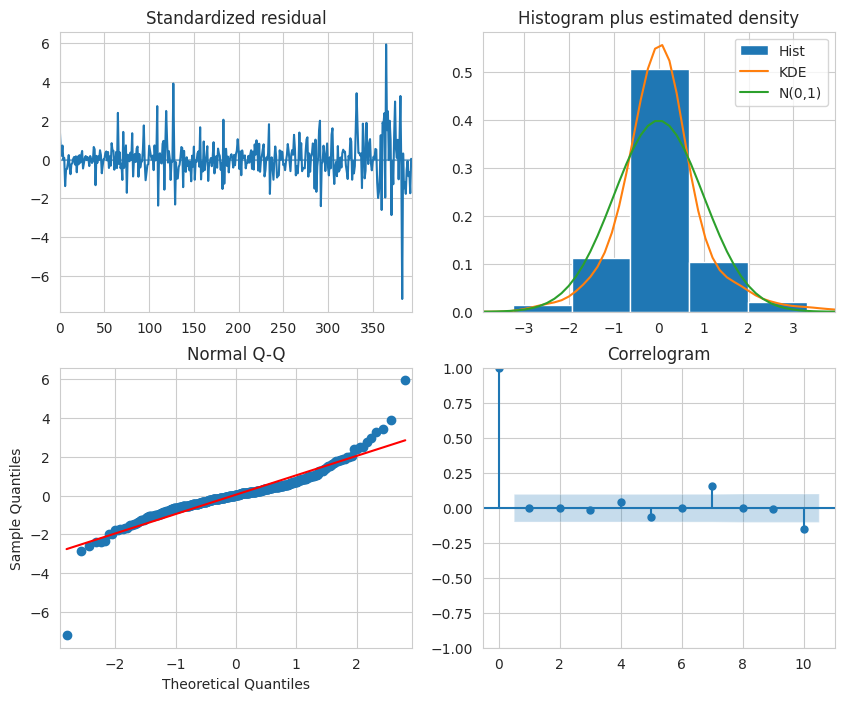

In [ ]:
auto_arima_results.plot_diagnostics(figsize=(10,8))
plt.show()

Interpretation of plots in plot diagnostics Standardized residual: The residual errors seem to fluctuate around a mean of zero and have a uniform variance. Histogram: The density plot suggest normal distribution with mean slightly shifted towards right. Theoretical Quantiles: Mostly the dots fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed. Correlogram: The Correlogram, (or ACF plot) shows the residual errors are not autocorrelated.

In [ ]:
# Train ARIMA model using p,d,q values from auto_arima

arima_model = ARIMA(sample_data_day["n_pubs"], order=(2,1,1))
arima_model_fit = arima_model.fit()

In [ ]:
normaltest(arima_model_fit.resid)
# If p value is not less than 0.05, that means Residuals are normally distributed

NormaltestResult(statistic=82.23259151537832, pvalue=1.3912963190952909e-18)

In [ ]:
# Make predictions on test
#start = len(sample_data_day["timestamp"])
#end = len(sample_data_day["timestamp"]) + len(test_data["timestamp"]) -1

#pred = arima_model_fit.get_prediction(start=start, end=end, dynamic=False, typ="levels")
pred = arima_model_fit.get_prediction(dynamic=False, typ="levels")
pred_days = arima_model_fit.get_forecast(steps=28)

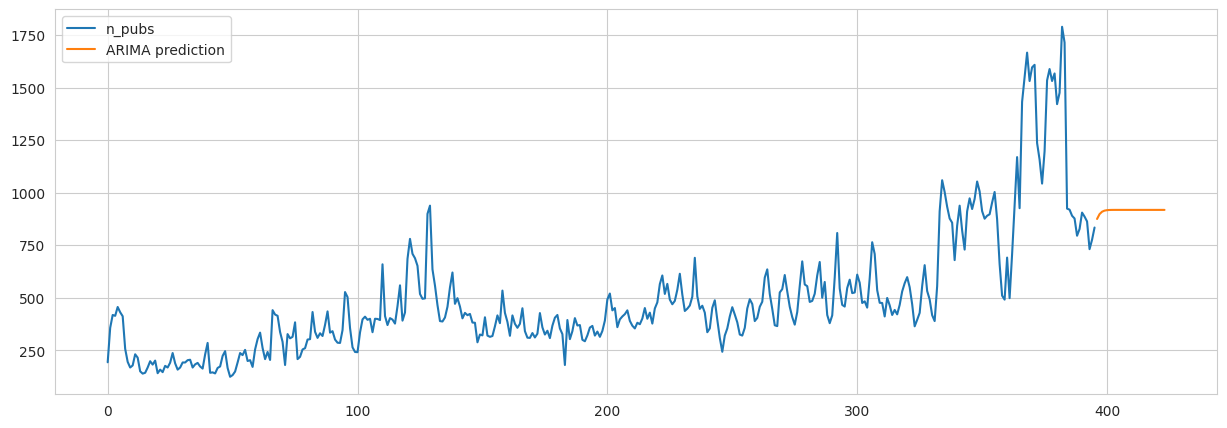

In [ ]:
predicted_values = pred.predicted_mean
forecast_values = pred_days.predicted_mean
confidence_intervals = pred.conf_int()

# Plot forecast with training data
ax = sample_data_day["n_pubs"].plot(figsize=(15,5))
#predicted_values.plot(label="ARIMA prediction")
forecast_values.plot(label="ARIMA prediction")
#plt.plot(test_data["n_pubs"], label="Test data")
plt.legend()
plt.show()

## Seasonal ARIMA

In [ ]:
"""no box_cox (1, 1, 1)(1, 0, 2, 14)
   no box_cox (1, 1, 2)(2, 0, 0, 7)
   box_cox (1, 1, 1)(2, 0, 1, 14)
   box_cox (1, 1, 2)(1, 0, 1, 7)"""
sarima_pred = []

In [ ]:
smodel = arima.auto_arima(sample_data_day["n_pubs"],
                    start_p=0,
                    start_q=0,
                    max_p=10,
                    max_q=10,
                    m=7,
                    start_P=0,
                    start_Q=0,
                    end_P=5,
                    end_Q=5,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=4787.313, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=4778.723, Time=1.07 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=4781.029, Time=1.63 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=4785.410, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=4788.778, Time=0.37 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=4772.590, Time=1.47 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=4.36 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=2.50 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=4770.597, Time=0.94 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=4777.187, Time=0.42 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=3.24 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.69 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=4772.588, Time=1.53 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=inf, Time=3.04 sec
 ARIMA(0,1,0)(2,0,0)[7]             : AIC=4768.621, Time=0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  396
Model:             SARIMAX(1, 1, 2)x(2, 0, [], 7)   Log Likelihood               -2365.594
Date:                            Mon, 09 Oct 2023   AIC                           4745.187
Time:                                    23:56:55   BIC                           4773.039
Sample:                                         0   HQIC                          4756.222
                                            - 396                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3057      0.191      1.597      0.110      -0.069       0.681
ar.L1          0.7791      0.041     19.157      0.000       0.699       0.859
ma.L1         -0.8374      0.046    -18.244      0.000      -0.927      -0.747
ma.L2         -0.1368      0.038     -3.578      0.000      -0.212      -0.062
ar.S.L7        0.1780      0.048      3.706      0.000       0.084       0.272
ar.S.L14       0.1320      0.053      2.477      0.013       0.028       0.236
sigma2      9291.1182    306.837     30.280      0.000    8689.729    9892.507
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1984.08
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               3.01   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

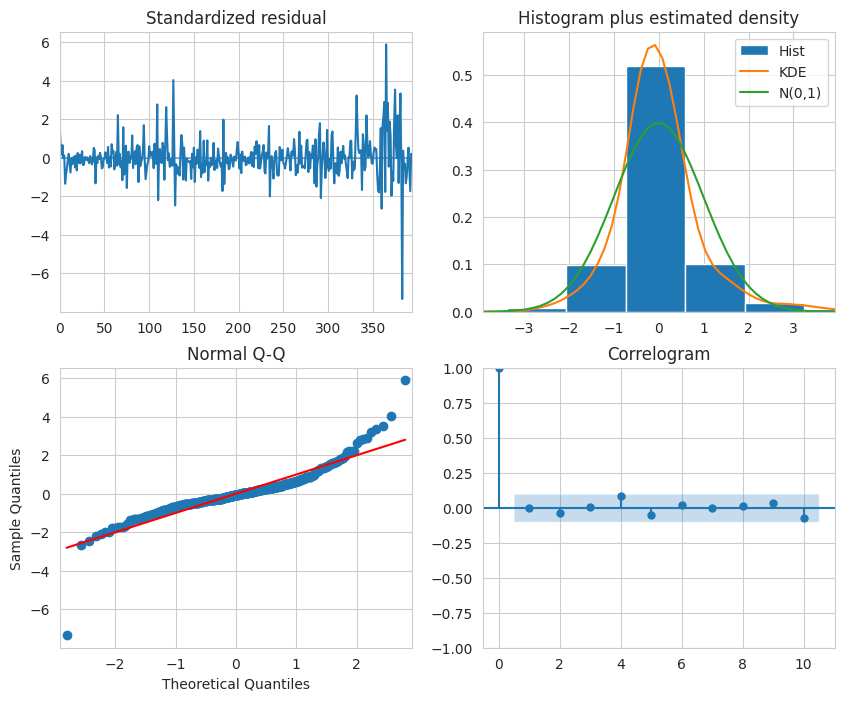

In [ ]:
smodel.plot_diagnostics(figsize=(10,8))
plt.show()

In [ ]:
sarima_model= SARIMAX(sample_data_day["n_pubs"], order= (1,1,2), seasonal_order= (2,0,0,7))
sarima_model_fit = sarima_model.fit()

#Make predictions on Test
# Make predictions on test
#start = len(sample_data_day["timestamp"])
#end = len(sample_data_day["timestamp"]) + len(test_data["timestamp"]) -1

pred = sarima_model_fit.get_prediction(dynamic=False, typ="levels")
pred_days = sarima_model_fit.get_forecast(steps=28)

sarima_pred.append([pred_days])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


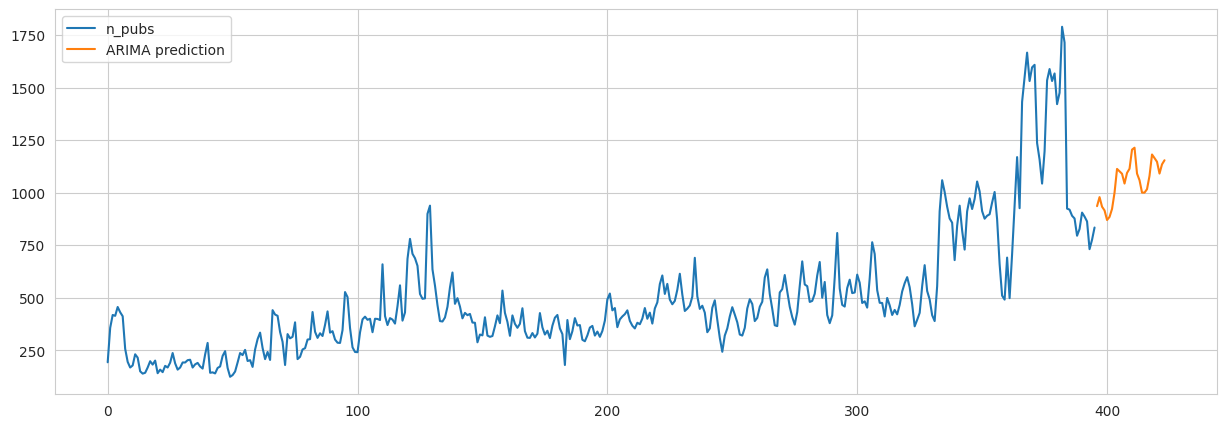

In [ ]:
#predicted_values = pred.predicted_mean
predicted_values = pred_days.predicted_mean
confidence_intervals = pred.conf_int()

# Plot forecast with training data
ax = sample_data_day["n_pubs"].plot(figsize=(15,5))
#predicted_values.plot(label="ARIMA prediction")
predicted_values.plot(label="ARIMA prediction")
#plt.plot(test_data["n_pubs"], label="Test data")
plt.legend()
plt.show()

##SARIMA with Box-Cox

In [ ]:
smodel = arima.auto_arima(sample_data_day["box_cox"],
                    start_p=0,
                    start_q=0,
                    max_p=10,
                    max_q=10,
                    m=7,
                    start_P=0,
                    start_Q=0,
                    end_P=5,
                    end_Q=5,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-740.942, Time=0.22 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-770.958, Time=1.00 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-761.677, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-742.801, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=-739.513, Time=0.17 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=-787.120, Time=2.22 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=-847.148, Time=3.93 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=-848.936, Time=1.41 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=-760.810, Time=0.51 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=-847.442, Time=6.74 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=-773.811, Time=2.76 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=-844.154, Time=2.50 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=-853.908, Time=2.27 sec
 ARIMA(2,1,0)(0,0,1)[7] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  396
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 7)   Log Likelihood                 440.236
Date:                             Tue, 10 Oct 2023   AIC                           -868.472
Time:                                     00:29:22   BIC                           -844.598
Sample:                                          0   HQIC                          -859.013
                                             - 396                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8484      0.051     16.735      0.000       0.749       0.948
ma.L1         -1.1246      0.056    -19.909      0.000      -1.235      -1.014
ma.L2          0.1500      0.048      3.121      0.002       0.056       0.244
ar.S.L7        0.9942      0.005    191.452      0.000       0.984       1.004
ma.S.L7       -0.9261      0.032    -28.575      0.000      -0.990      -0.863
sigma2         0.0061      0.000     19.046      0.000       0.006       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               103.41
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

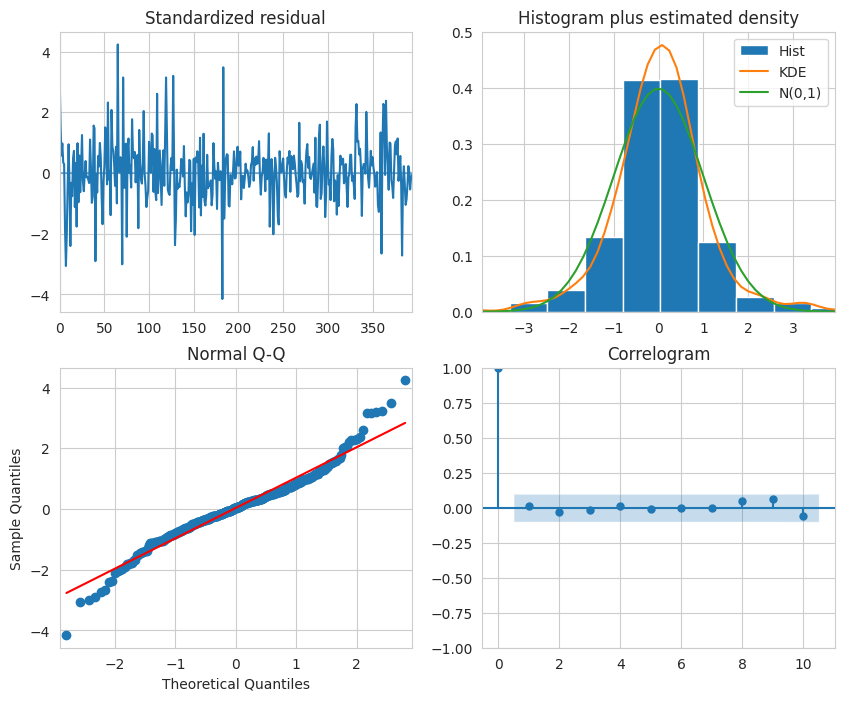

In [ ]:
smodel.plot_diagnostics(figsize=(10,8))
plt.show()

In [ ]:
sarima_model= SARIMAX(sample_data_day["box_cox"], order= (1,1,2), seasonal_order= (1,0,1,7))
sarima_model_fit = sarima_model.fit()

#Make predictions on Test
# Make predictions on test
#start = len(sample_data_day["timestamp"])
#end = len(sample_data_day["timestamp"]) + len(test_data["timestamp"]) -1

pred = sarima_model_fit.get_prediction(dynamic=False, typ="levels")
pred_days = sarima_model_fit.get_forecast(steps=28)

sarima_pred.append([pred_days])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


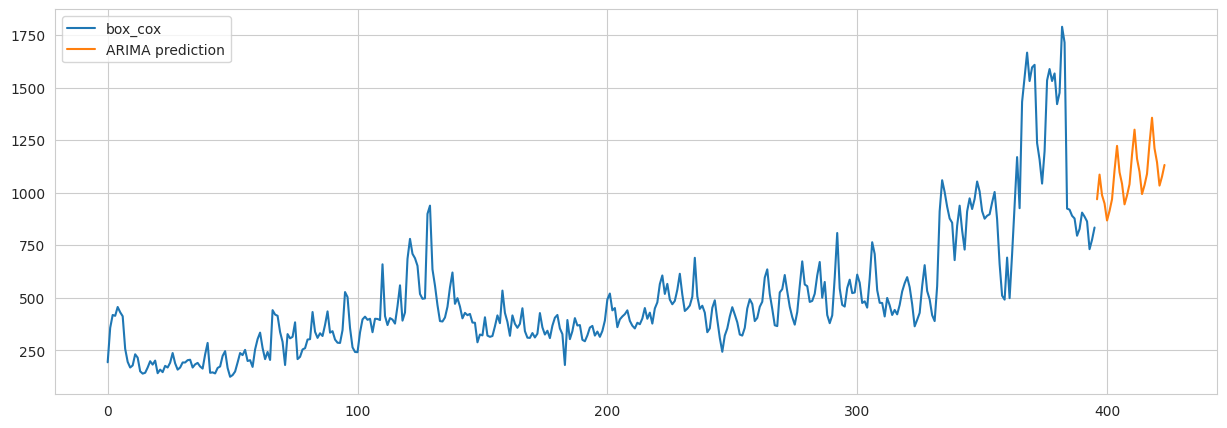

In [ ]:
#predicted_values = pred.predicted_mean
predicted_values = pred_days.predicted_mean
confidence_intervals = pred.conf_int()

# Plot forecast with training data
ax = invboxcox(sample_data_day["box_cox"], box_cox_lmbd).plot(figsize=(15,5))
#predicted_values.plot(label="ARIMA prediction")
invboxcox(predicted_values, box_cox_lmbd).plot(label="ARIMA prediction")
#plt.plot(test_data["n_pubs"], label="Test data")
plt.legend()
plt.show()

##Metrics

In [ ]:
valid_df

,hour,lat,lon,point,sum,error
0,1582448400,59.92698583598656,30.318140839033845,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,5,0.4214019228009757
1,1582225200,59.92473501631175,30.241784039883687,0101000020E6100000C5FE0F8FE53D3E4033438EB75DF6...,14,0.3102908116898645
2,1581260400,60.00230010204685,30.295682956930857,0101000020E6100000AB00D6E0B14B3E40CB88A75E4B00...,5,3.754735256134309
3,1581958800,59.935987587847,30.324878203664746,0101000020E61000005DECCB372B533E40E4A1F770CEF7...,7,0.504735256134309
4,1582779600,59.93373737889392,30.30691189798236,0101000020E6100000669634C7914E3E407AB3D8B484F7...,14,1.5547352561343089
...,...,...,...,...,...,...
681,1580659200,59.90559688321354,30.29792874514116,0101000020E61000006AEBE80E454C3E407F614299EAF3...,7,2.254735256134309
682,1581048000,59.95061022518379,30.315895050823546,0101000020E61000006141807FDE503E402B348A98ADF9...,8,6.754735256134309
683,1581656400,59.93373737889392,30.30915768619265,0101000020E6100000268147F5244F3E407AB3D8B484F7...,6,4.754735256134309
684,1580724000,59.931487017270754,30.358565026819228,0101000020E61000008EADE7EACA5B3E40CAE971F73AF7...,8,1.4214019228009758


In [ ]:
valid_data_error

,hour,lat,lon,point,sum,error
4,1582779600,59.93373737889392,30.30691189798236,0101000020E6100000669634C7914E3E407AB3D8B484F7...,14,1.5547352561343089
143,1581609600,59.93373737889392,30.30691189798236,0101000020E6100000669634C7914E3E407AB3D8B484F7...,35,5.754735256134309
201,1582938000,59.93373737889392,30.30691189798236,0101000020E6100000669634C7914E3E407AB3D8B484F7...,5,3.754735256134309
221,1581757200,59.93373737889392,30.30691189798236,0101000020E6100000669634C7914E3E407AB3D8B484F7...,27,0.234600918383829
227,1581019200,59.93373737889392,30.30691189798236,0101000020E6100000669634C7914E3E407AB3D8B484F7...,37,4.921401922800976
335,1581307200,59.93373737889392,30.30691189798236,0101000020E6100000669634C7914E3E407AB3D8B484F7...,10,1.254735256134309
390,1581368400,59.93373737889392,30.30691189798236,0101000020E6100000669634C7914E3E407AB3D8B484F7...,22,1.897592398991452
512,1581976800,59.93373737889392,30.30691189798236,0101000020E6100000669634C7914E3E407AB3D8B484F7...,37,6.154735256134309
611,1580752800,59.93373737889392,30.30691189798236,0101000020E6100000669634C7914E3E407AB3D8B484F7...,35,3.7547352561343095
676,1583013600,59.93373737889392,30.30691189798236,0101000020E6100000669634C7914E3E407AB3D8B484F7...,18,1.406575552204406


In [ ]:
sarima_pred[0] = sarima_pred[0][0].predicted_mean
sarima_pred[1] = sarima_pred[1][0].predicted_mean

sarima_pred[2] = invboxcox(sarima_pred[2][0].predicted_mean, box_cox_lmbd)
sarima_pred[3] = invboxcox(sarima_pred[3][0].predicted_mean, box_cox_lmbd)

In [ ]:
valid_data_error["hour_datetime"] = [datetime.datetime.fromtimestamp(int(timestamp)) for timestamp in valid_data_error["hour"].values]
# Get predicted timestamps
start_pred_timestamp = sample_data.index

<ipython-input-114-ac300dcde73b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data_error["hour_datetime"] = [datetime.datetime.fromtimestamp(int(timestamp)) for timestamp in valid_data_error["hour"].values]


In [ ]:
valid_data_error

,hour,lat,lon,point,sum,error,hour_datetime
4,1582779600,59.93373737889392,30.30691189798236,0101000020E6100000669634C7914E3E407AB3D8B484F7...,14,1.5547352561343089,2020-02-27 05:00:00
143,1581609600,59.93373737889392,30.30691189798236,0101000020E6100000669634C7914E3E407AB3D8B484F7...,35,5.754735256134309,2020-02-13 16:00:00
201,1582938000,59.93373737889392,30.30691189798236,0101000020E6100000669634C7914E3E407AB3D8B484F7...,5,3.754735256134309,2020-02-29 01:00:00
221,1581757200,59.93373737889392,30.30691189798236,0101000020E6100000669634C7914E3E407AB3D8B484F7...,27,0.234600918383829,2020-02-15 09:00:00
227,1581019200,59.93373737889392,30.30691189798236,0101000020E6100000669634C7914E3E407AB3D8B484F7...,37,4.921401922800976,2020-02-06 20:00:00
335,1581307200,59.93373737889392,30.30691189798236,0101000020E6100000669634C7914E3E407AB3D8B484F7...,10,1.254735256134309,2020-02-10 04:00:00
390,1581368400,59.93373737889392,30.30691189798236,0101000020E6100000669634C7914E3E407AB3D8B484F7...,22,1.897592398991452,2020-02-10 21:00:00
512,1581976800,59.93373737889392,30.30691189798236,0101000020E6100000669634C7914E3E407AB3D8B484F7...,37,6.154735256134309,2020-02-17 22:00:00
611,1580752800,59.93373737889392,30.30691189798236,0101000020E6100000669634C7914E3E407AB3D8B484F7...,35,3.7547352561343095,2020-02-03 18:00:00
676,1583013600,59.93373737889392,30.30691189798236,0101000020E6100000669634C7914E3E407AB3D8B484F7...,18,1.406575552204406,2020-02-29 22:00:00


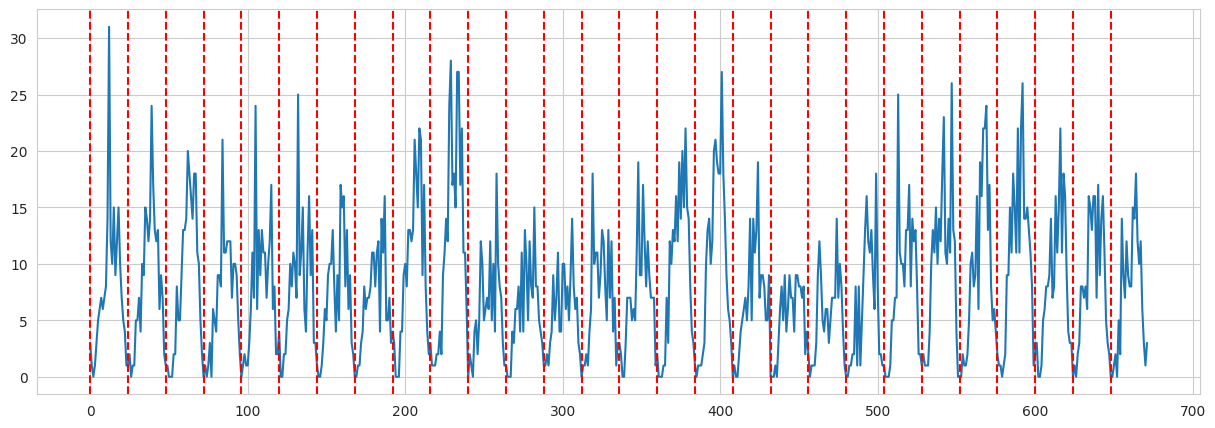

In [ ]:
start_time = datetime.datetime.fromtimestamp(train_sample_no_split.index[-1]) - relativedelta(years=1)
time_period = [(start_time + datetime.timedelta(hours=i)).timestamp() for i in range(1, 24*28+1)]

# Extract data for the specified period
data_period = train_sample_no_split.loc[time_period].values

data_period_df = pd.DataFrame({"Timestamp": time_period, "Data": data_period })

data_len = len(data_period)
line_id = 0
fig, ax = plt.subplots(figsize=(15, 5))

plt.plot(data_period)

while data_len > 0:
    ax.axvline(line_id, color="red", linestyle="--")
    line_id += 24
    data_len -= 24

In [ ]:
# Extract all days from validation set
valid_days = [timest.day for timest in valid_data_error["hour_datetime"]]

27


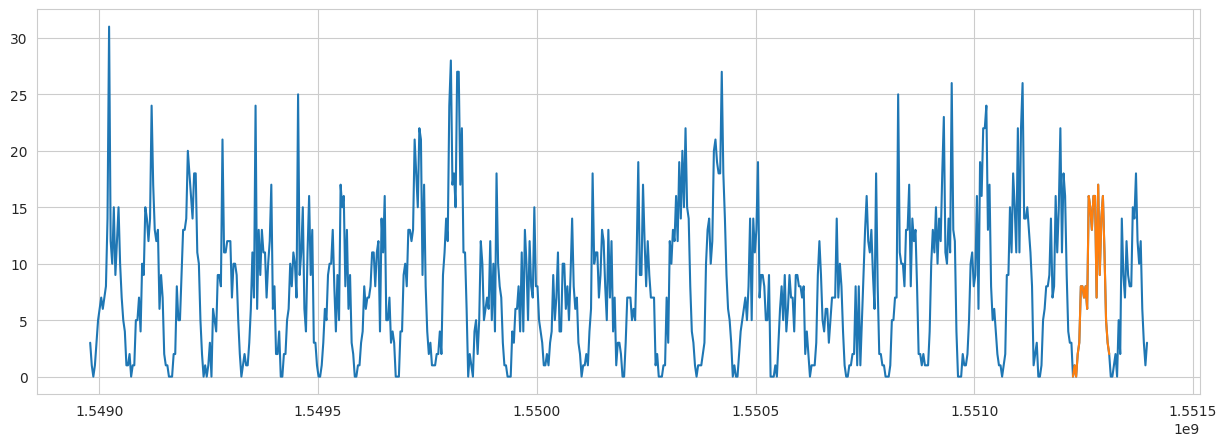

In [ ]:
# Fit one day
print(valid_days[0])
valid_day = data_period_df[(valid_days[0]-1)*24:valid_days[0]*24]
plt.figure(figsize=(15,5))
plt.plot(data_period_df["Timestamp"], data_period_df["Data"])
plt.plot(valid_day["Timestamp"], valid_day["Data"])

In [ ]:
valid_day["mask"] = valid_day["Data"] / valid_day["Data"].sum()
valid_day["pred"] = valid_day["mask"] * sarima_pred[2].iloc[valid_days[0]-1]

<ipython-input-226-5e149a73a76a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_day["mask"] = valid_day["Data"] / valid_day["Data"].sum()
<ipython-input-226-5e149a73a76a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_day["pred"] = valid_day["mask"] * sarima_pred[2].iloc[valid_days[0]-1]


In [ ]:
valid_day["pred"].iloc[5]

38.82753163164457

In [ ]:
valid_day["pred"]

624     0.000000
625     4.853441
626     0.000000
627     9.706883
628    14.560324
629    38.827532
630    38.827532
631    33.974090
632    38.827532
633    29.120649
634    77.655063
635    72.801622
636    63.094739
637    77.655063
638    77.655063
639    33.974090
640    82.508505
641    43.680973
642    67.948180
643    77.655063
644    53.387856
645    24.267207
646    14.560324
647     9.706883
Name: pred, dtype: float64

Best degree 3 with RMSE 3.5199690477519985


Text(0, 0.5, 'RMSE')

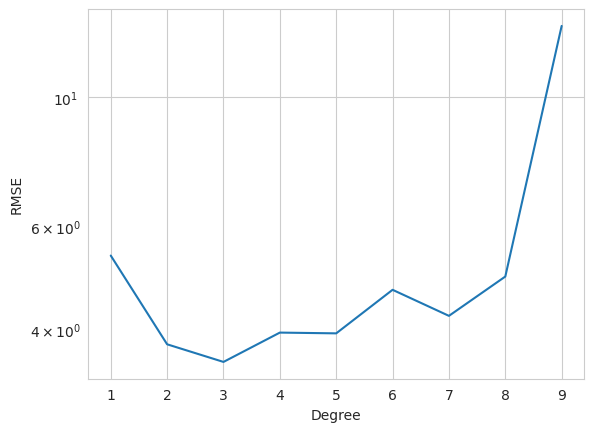

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X = np.array([i for i in range(len(valid_day))]).reshape(len(valid_day), 1)
y = valid_day["Data"].values.reshape(len(valid_day), 1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

rmses = []
degrees = np.arange(1, 10)
min_rmse, min_deg = 1e10, 0

for deg in degrees:

    # Train features
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)

    x_poly_train = poly_features.fit_transform(x_train)

    # Linear regression
    poly_reg = LinearRegression()
    poly_reg.fit(x_poly_train, y_train)

    # Compare with test data
    x_poly_test = poly_features.fit_transform(x_test)
    poly_predict = poly_reg.predict(x_poly_test)
    poly_mse = mean_squared_error(y_test, poly_predict)
    poly_rmse = np.sqrt(poly_mse)
    rmses.append(poly_rmse)

    # Cross-validation of degree
    if min_rmse > poly_rmse:
        min_rmse = poly_rmse
        min_deg = deg

# Plot and present results
print('Best degree {} with RMSE {}'.format(min_deg, min_rmse))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(degrees, rmses)
ax.set_yscale('log')
ax.set_xlabel('Degree')
ax.set_ylabel('RMSE')

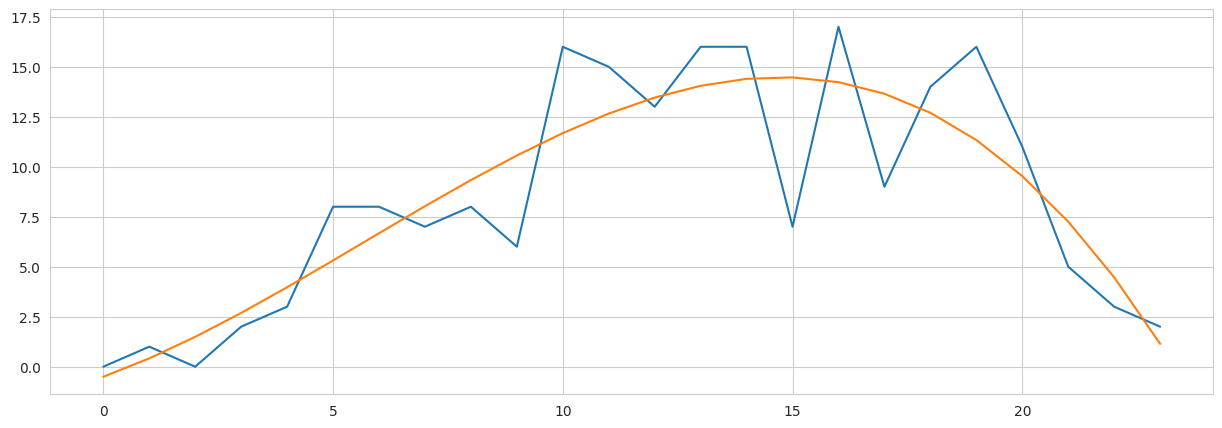

In [ ]:
# fit the model to a given degree, 1 in this case
trend = np.polyfit(X.ravel(), y.ravel(), 3)

plt.figure(figsize=(15,5))

# plot the scatter points
plt.plot(X, y)

# calculate the trendline
trendpoly = np.poly1d(trend)

# plot the trend line
plt.plot(X, trendpoly(X))